<a href="https://colab.research.google.com/github/BarGinger/Depp_Leraning_Laser/blob/main/LSTM%20with_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
%pip install optuna
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.7 MB/s eta 0:00:00


## Global Definitions

In [4]:
# Path to the zip file
data_dir = "/content/"
data_path = f"{data_dir}/Xtrain.mat"
output_dir = "./Output"
model_dir = "./Models"
test_data_path = f"{data_dir}/Xtest.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "LSTM_WITH_DROPOUT"
model_pth_path = f"{model_dir}/best_model_{model_name}.pth"
random.seed(42)

In [ ]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities

In [5]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=25):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step(avg_val_mae_loss)

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Gated recurrent units (GRUs) RNN Model

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True,
                              dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


### Load and Split the dataset into train-validation

In [7]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 100  # Maximum window size
# Split data into training and validation sets
# size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data = measurements
val_data = add_noise(measurements, std=0.02)  # Adding noise to the validation data
# train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

# load the test data
test_data = loadmat(test_data_path)
test_measurements = test_data['Xtest']
print("Shape of test measurements:", test_measurements.shape)
print(f"test_measurements range: min={test_measurements.min()}, max={test_measurements.max()}")
test_data_normalized = scaler.transform(test_measurements)
print(f"test_data_normalized range: min={test_data_normalized.min()}, max={test_data_normalized.max()}")
test_dataset = test_data_normalized


Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (1000, 1), Val shape: (1000, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=-0.00011288103218888741, max=0.9999657581746699
Shape of test measurements: (200, 1)
test_measurements range: min=3, max=255
test_data_normalized range: min=0.003952569169960474, max=1.0


Training dataset plot saved to ./Output/train_dataset_plot.png


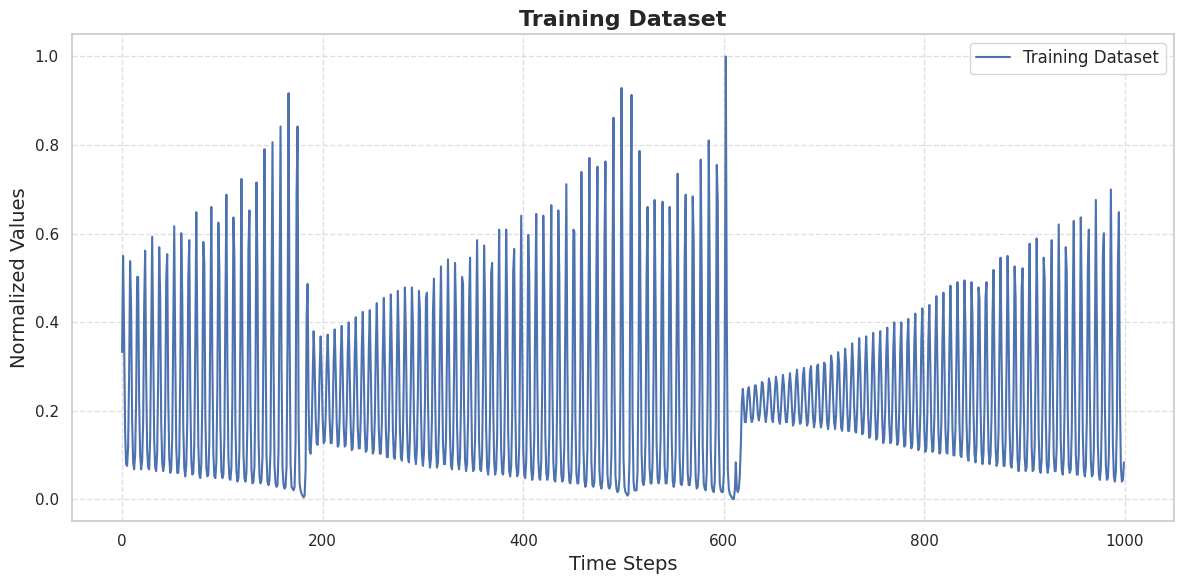

Validation dataset plot saved to ./Output/val_dataset_plot.png


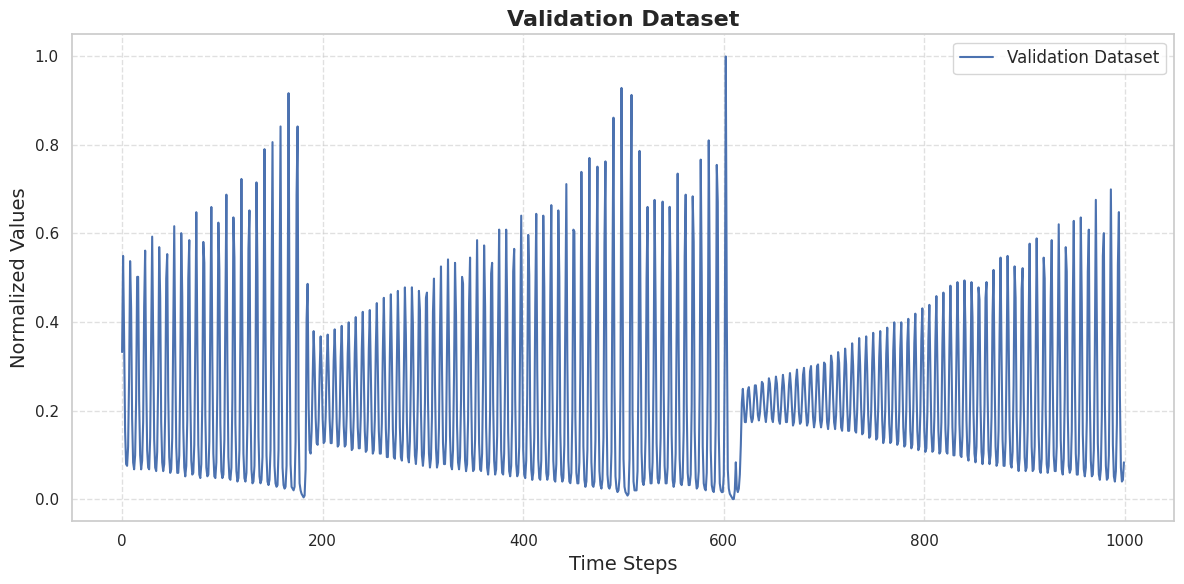

Test dataset plot saved to ./Output/test_dataset_plot.png


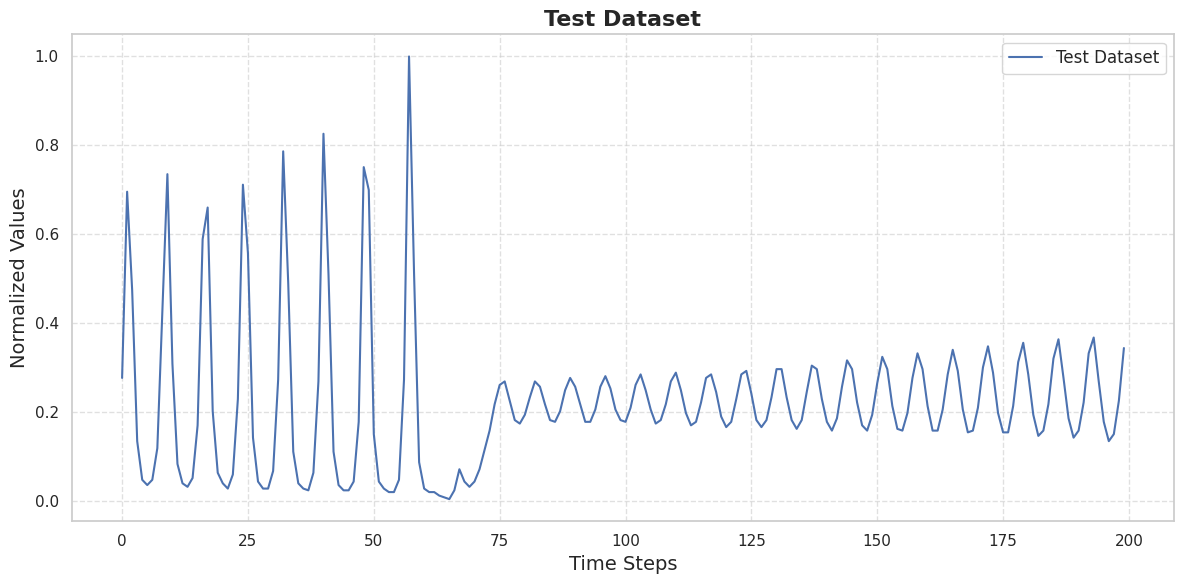

In [8]:
import matplotlib.pyplot as plt

def plot_dataset(dataset, dataset_name, save_path=None):
    """
    Plot a dataset with a given name.

    Args:
        dataset (np.ndarray): The dataset to plot (e.g., train, validation, or test).
        dataset_name (str): The name of the dataset (e.g., "Training", "Validation", "Test").
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dataset, label=f"{dataset_name} Dataset", linewidth=1.5)
    plt.xlabel("Time Steps", fontsize=14)
    plt.ylabel("Normalized Values", fontsize=14)
    plt.title(f"{dataset_name} Dataset", fontsize=16, weight="bold")
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        print(f"{dataset_name} dataset plot saved to {save_path}")

    plt.show()

# Example usage
plot_dataset(train_dataset, "Training", save_path=f"{output_dir}/train_dataset_plot.png")
plot_dataset(val_dataset, "Validation", save_path=f"{output_dir}/val_dataset_plot.png")
plot_dataset(test_dataset, "Test", save_path=f"{output_dir}/test_dataset_plot.png")

### Training the Model

In [9]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE",
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 128, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 2, 10, step=2)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 40, 100, step=10)
    dropout = trial.suggest_float('dropout', 0.1, 0.4, step=0.1)

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = LSTM(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=200, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=10)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"{output_dir}/all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
# Load the best model
best_model = LSTM(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-09 12:19:57,363] A new study created in memory with name: no-name-b17b4880-2a40-4776-aea7-77f62302938f


Trial: 1:   0%|          | 0/200 [00:00<?, ?epoch/s]

<ipython-input-9-84adfa25c145>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-09 12:22:38,216] Trial 0 finished with value: 0.024415183719247578 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 5.279078420267997e-05, 'batch_size': 64, 'window_size': 80, 'dropout': 0.2}. Best is trial 0 with value: 0.024415183719247578.


Best model saved with trial 0


Trial: 2:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:23:26,610] Trial 1 finished with value: 0.005965952905986844 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.006439693597217279, 'batch_size': 32, 'window_size': 80, 'dropout': 0.30000000000000004}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 175 epochs.
Best model saved with trial 1


Trial: 3:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:27:07,839] Trial 2 finished with value: 0.14035351884861788 and parameters: {'hidden_size': 192, 'num_layers': 4, 'lr': 6.106489528741205e-05, 'batch_size': 32, 'window_size': 50, 'dropout': 0.4}. Best is trial 1 with value: 0.005965952905986844.


Trial: 4:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:27:56,021] Trial 3 finished with value: 0.006197361562711497 and parameters: {'hidden_size': 128, 'num_layers': 4, 'lr': 0.008605266096283527, 'batch_size': 32, 'window_size': 60, 'dropout': 0.4}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 145 epochs.


Trial: 5:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:28:14,633] Trial 4 finished with value: 0.01136260840576142 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0008855478386359977, 'batch_size': 128, 'window_size': 50, 'dropout': 0.4}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 177 epochs.


Trial: 6:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:28:41,796] Trial 5 finished with value: 0.13465636409819126 and parameters: {'hidden_size': 224, 'num_layers': 6, 'lr': 0.008352341416537287, 'batch_size': 128, 'window_size': 100, 'dropout': 0.1}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 35 epochs.


Trial: 7:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:32:56,337] Trial 6 finished with value: 0.008185059872145455 and parameters: {'hidden_size': 192, 'num_layers': 4, 'lr': 0.00023758981978655054, 'batch_size': 32, 'window_size': 60, 'dropout': 0.2}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 199 epochs.


Trial: 8:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:36:51,727] Trial 7 finished with value: 0.007267379405675456 and parameters: {'hidden_size': 160, 'num_layers': 6, 'lr': 0.003171566289397074, 'batch_size': 128, 'window_size': 70, 'dropout': 0.2}. Best is trial 1 with value: 0.005965952905986844.


Trial: 9:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:37:39,820] Trial 8 finished with value: 0.13108987547457218 and parameters: {'hidden_size': 160, 'num_layers': 10, 'lr': 0.0028258935281245136, 'batch_size': 128, 'window_size': 50, 'dropout': 0.4}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 33 epochs.


Trial: 10:   0%|          | 0/200 [00:00<?, ?epoch/s]

[I 2025-05-09 12:39:25,940] Trial 9 finished with value: 0.14080785761276882 and parameters: {'hidden_size': 224, 'num_layers': 10, 'lr': 0.000563974304836885, 'batch_size': 64, 'window_size': 80, 'dropout': 0.2}. Best is trial 1 with value: 0.005965952905986844.


Early stopping triggered after 92 epochs.
All metrics saved to ./Output/all_trials_metrics_LSTM_WITH_DROPOUT.csv
Best hyperparameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.006439693597217279, 'batch_size': 32, 'window_size': 80, 'dropout': 0.30000000000000004}
Best validation loss: 0.005965952905986844
Best model loaded.
Data loaders updated with best hyperparameters.


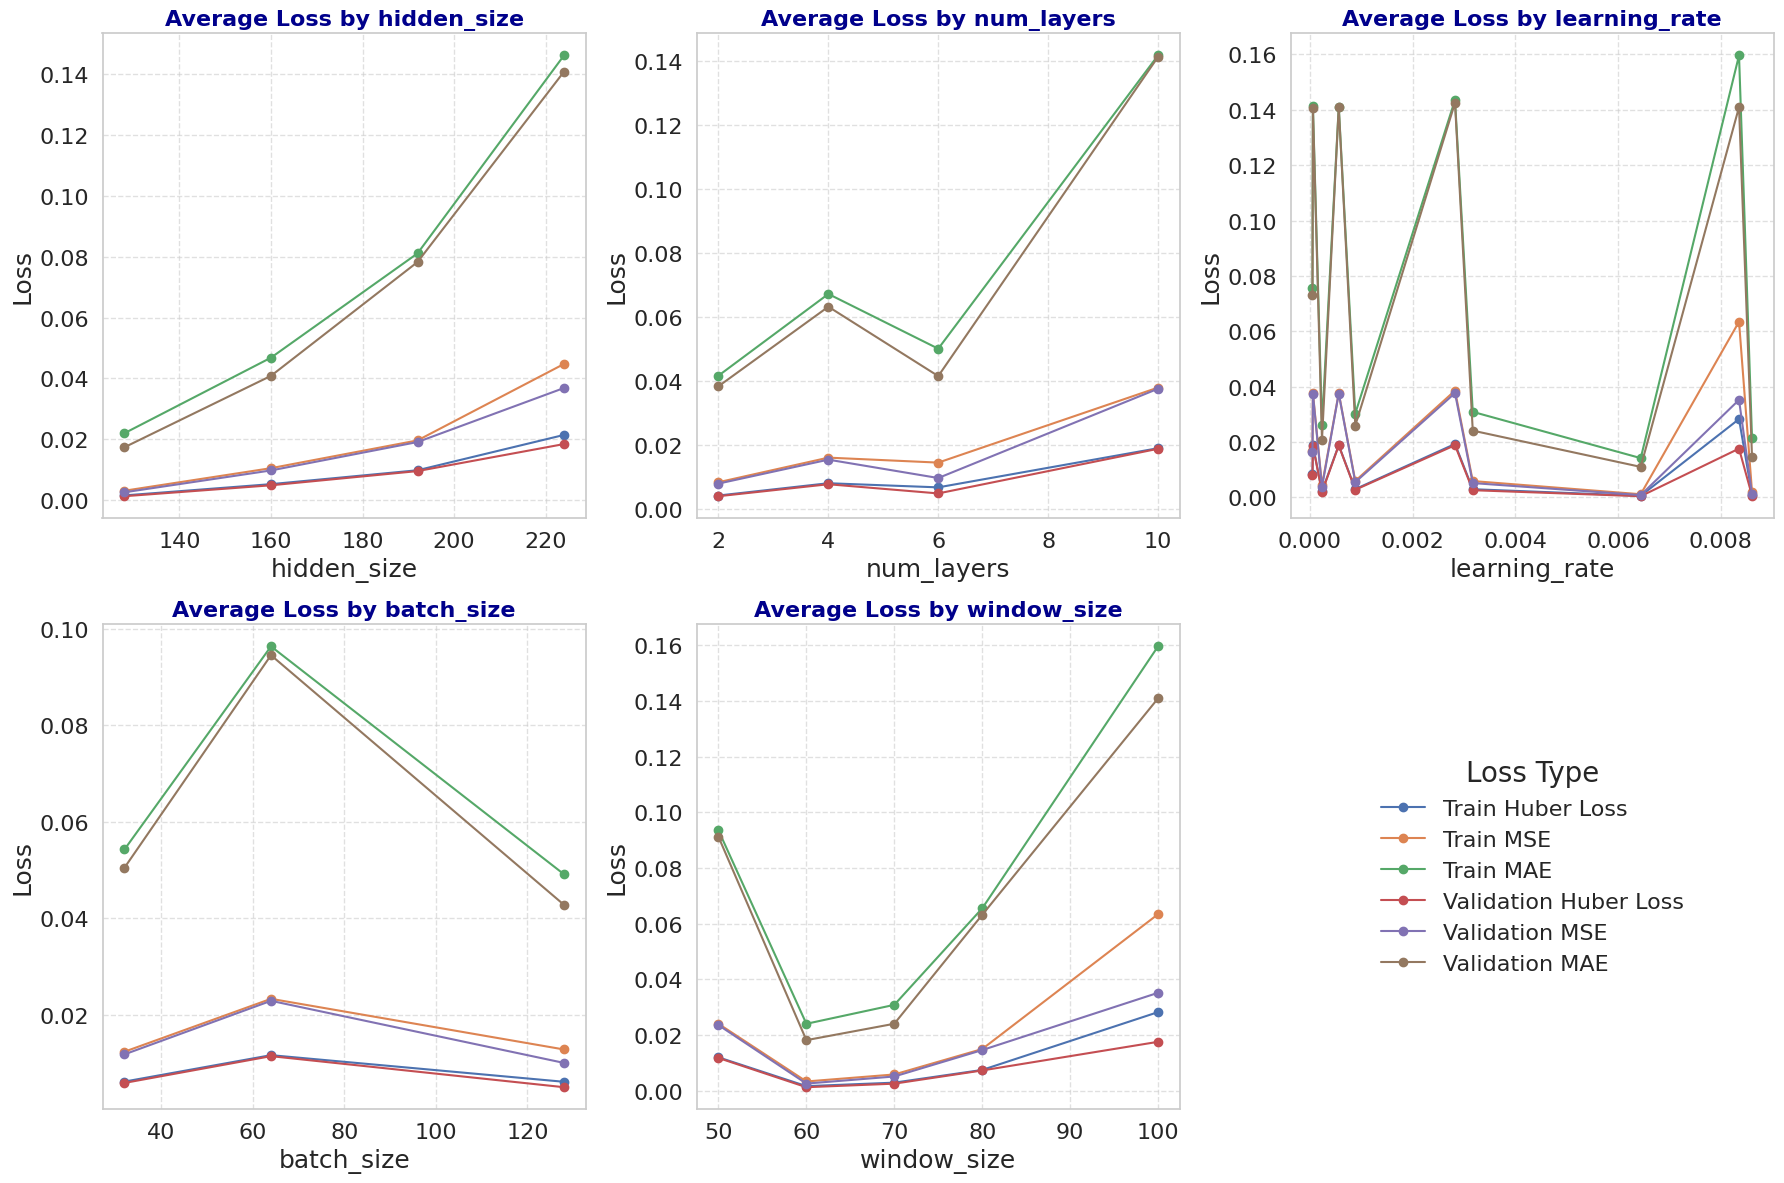

In [10]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"{output_dir}/metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

<ipython-input-11-f6f12748b766>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


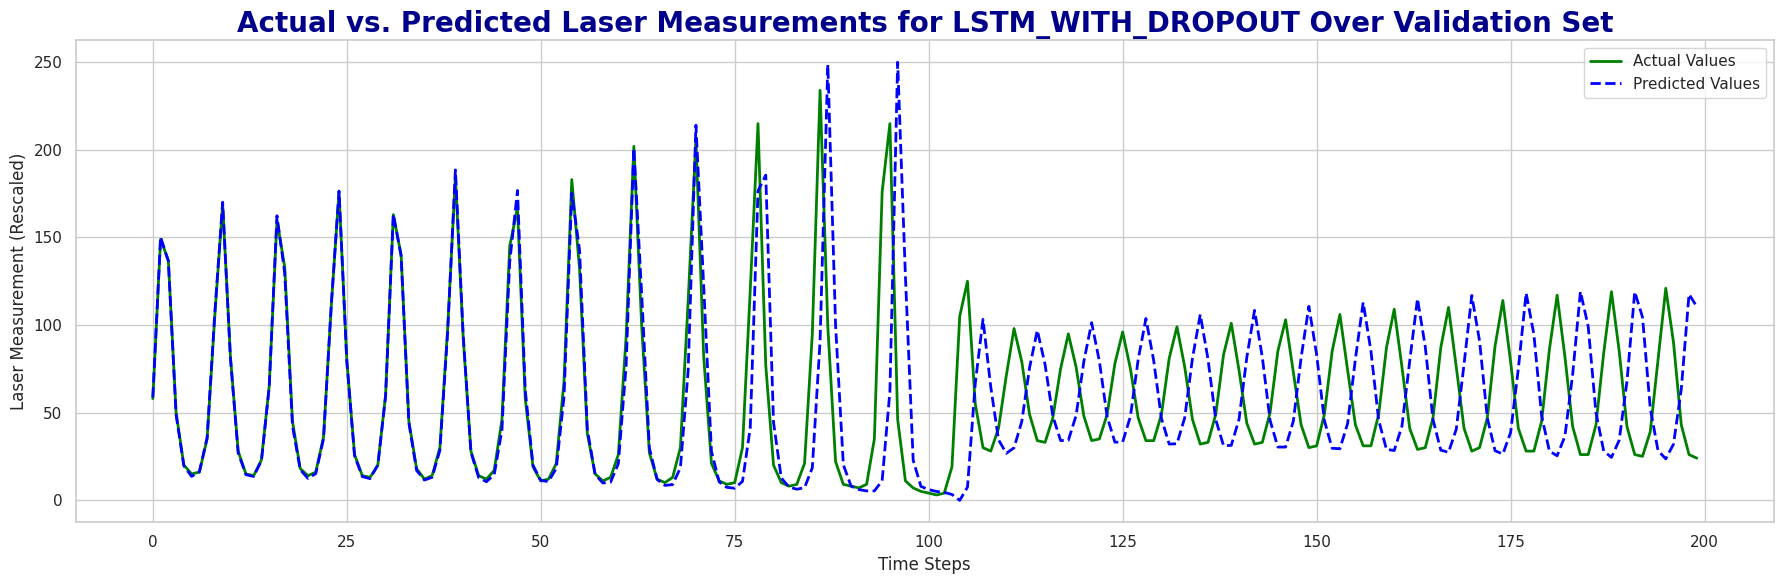

Metrics plot saved to ./Output/actual_vs_predicted_plot_LSTM_WITH_DROPOUT_val.png


In [11]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained Gated recurrent units (GRUs) model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path, daateset_name=""):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title(f"Actual vs. Predicted Laser Measurements for {model_name} Over {daateset_name}", fontsize=20, weight='bold', color='darkblue')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")

# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_val.png", "Validation Set")

### Load the trained model

In [14]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = LSTM(
        input_size=1,
        hidden_size=best_params['hidden_size'],
        num_stacked_layers=best_params['num_layers'],
        dropout = best_params['dropout']
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

# Update data loaders with the suggested batch size
window_size = best_params['window_size']
batch_size = best_params['batch_size']
train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)
test_loader, test_X, test_y = prepare_dataloader(test_dataset, window_size, batch_size=batch_size)

Best hyperparameters are: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.006439693597217279, 'batch_size': 32, 'window_size': 80, 'dropout': 0.30000000000000004}


## Evaluate the model

In [15]:
import torch.nn as nn

def evaluate_model(best_model, val_loader, dataset_name, scaler):
    """
    Evaluate the best model on given dataset and calculate MSE and MAE in the unnormalized scale.

    Args:
        best_model: The trained model.
        val_loader: The given dataset (normalized).
        dataset_name: Name of the dataset (e.g., "Training", "Validation", "Test").
        scaler: The MinMaxScaler used for normalization.

    Returns:
        mse: Mean Squared Error (unnormalized).
        mae: Mean Absolute Error (unnormalized).
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Inverse transform predictions and ground truth to the original scale
            output_unnormalized = scaler.inverse_transform(output.cpu().numpy())
            y_batch_unnormalized = scaler.inverse_transform(y_batch.cpu().numpy())

            # Convert back to tensors for loss calculation
            output_unnormalized = torch.tensor(output_unnormalized, dtype=torch.float32)
            y_batch_unnormalized = torch.tensor(y_batch_unnormalized, dtype=torch.float32)

            # Calculate losses
            mse = mse_criterion(output_unnormalized, y_batch_unnormalized).item()
            mae = mae_criterion(output_unnormalized, y_batch_unnormalized).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"For model: {model_name} - {dataset_name} Evaluation:")
    print(f"{dataset_name} MSE (unnormalized): {avg_mse}")
    print(f"{dataset_name} MAE (unnormalized): {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model(best_model, train_loader, "Training", scaler)
mse, mae = evaluate_model(best_model, val_loader, "Validation", scaler)
mse, mae = evaluate_model(best_model, test_loader, "Test", scaler)

For model: LSTM_WITH_DROPOUT - Training Evaluation:
Training MSE (unnormalized): 13.526838253373684
Training MAE (unnormalized): 1.5153494280317554
For model: LSTM_WITH_DROPOUT - Validation Evaluation:
Validation MSE (unnormalized): 13.523203080115112
Validation MAE (unnormalized): 1.515894529612168
For model: LSTM_WITH_DROPOUT - Test Evaluation:
Test MSE (unnormalized): 2.658437983194987
Test MAE (unnormalized): 1.276284964879354


Predicted signal shape: (200, 1)
Actual signal shape: (200, 1)


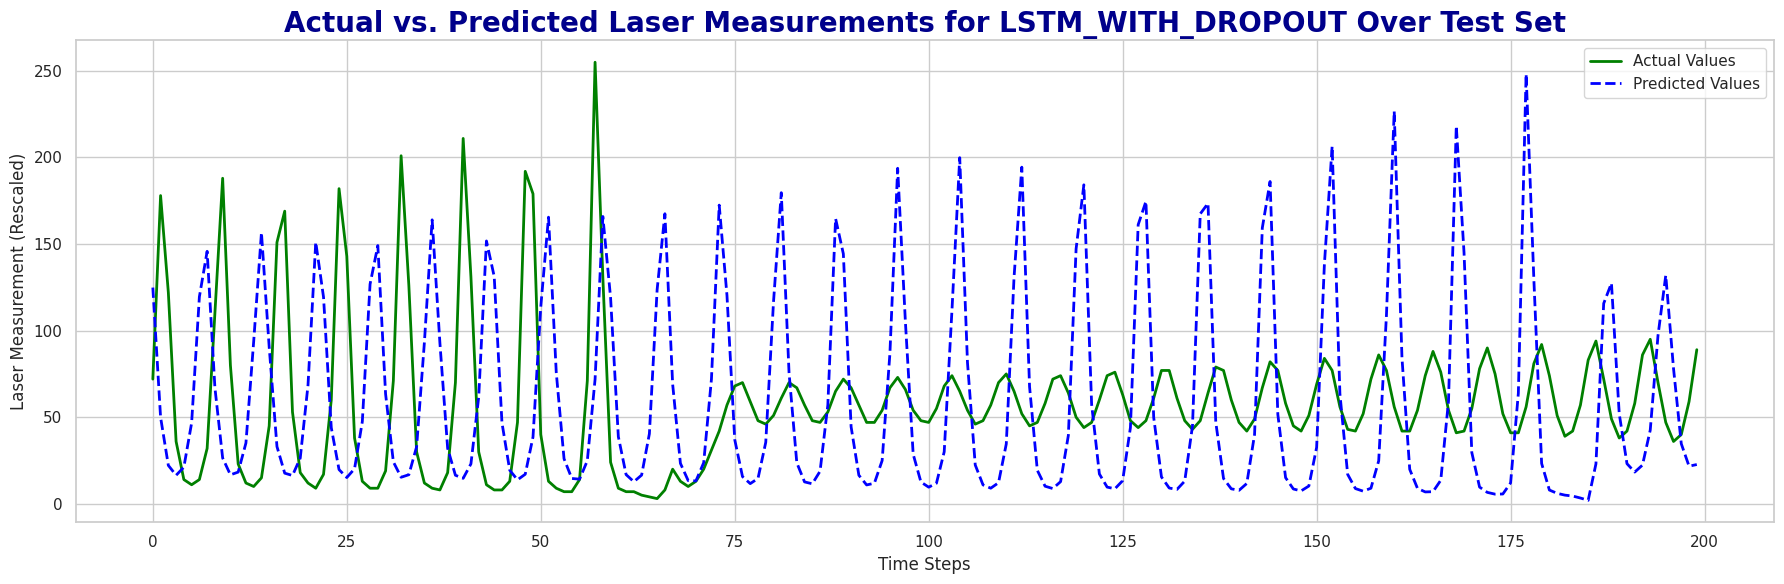

Metrics plot saved to ./Output/actual_vs_predicted_plot_LSTM_WITH_DROPOUT_test.png


In [16]:
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
last_window = measurements[:-window_size]
last_window_normalized = scaler.transform(last_window)
init_window = torch.tensor(last_window_normalized, dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)
print(f"Predicted signal shape: {predicted_signal.shape}")

# Compare with the actual values (also inverse transformed if needed)
actual_signal = test_measurements

print(f"Actual signal shape: {actual_signal.shape}")

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_test.png", "Test Set")

## Plot for results

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files for RNN, LSTM, and GRU
rnn_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_RNN.csv")
lstm_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_LSTM.csv")
gru_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_GRU.csv")

# Add a column to identify the model
rnn_metrics["model"] = "RNN"
lstm_metrics["model"] = "LSTM"
gru_metrics["model"] = "GRU"

# Combine all metrics into a single DataFrame
all_metrics = pd.concat([rnn_metrics, lstm_metrics, gru_metrics], ignore_index=True)

# Define the parameters to plot
parameters_to_plot = ["hidden_size", "num_layers", "window_size", "batch_size"]

# Ensure all columns in parameters_to_plot are numeric and drop rows with NaN values
for param in parameters_to_plot:
    if param in all_metrics.columns:
        all_metrics[param] = pd.to_numeric(all_metrics[param], errors="coerce")
all_metrics = all_metrics.dropna(subset=parameters_to_plot)

# Define the loss functions to plot
loss_functions = {
    "MSE": ["train_MSE", "val_MSE"],
    "MAE": ["train_MAE", "val_MAE"]
}

# Define a mapping for paper-friendly parameter names
parameter_name_mapping = {
    "hidden_size": "Hidden Size",
    "num_layers": "Number of Layers",
    "window_size": "Window Size",
    "batch_size": "Batch Size"
}

# Replace parameter names in the parameters_to_plot list
parameters_to_plot = [parameter_name_mapping[param] for param in parameters_to_plot]

# Define colors for models
model_colors = {
    "RNN": ("blue", "darkblue"),
    "LSTM": ("mediumpurple", "purple"),
    "GRU": ("red", "darkred")
}

# Function to plot metrics for each loss function
# Function to plot metrics for each loss function
def plot_loss_metrics(metrics_df, loss_type, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses for train and validation.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        loss_type (str): The loss type to plot (e.g., "MSE", "MAE").
        parameters (list): List of parameters to plot (e.g., ['Hidden Size', 'Number of Layers', 'Window Size', 'Batch Size']).
        save_path (str): Path to save the plot.
    """
    loss_columns = loss_functions[loss_type]
    num_params = len(parameters)
    ncols = 2  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Define markers for train and validation sets
    markers = {"train": "o", "val": "s"}  # Circle for train, square for validation
    linestyles = {"train": "-", "val": ":"}  # Solid for train, dotted for validation

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        original_param = [key for key, value in parameter_name_mapping.items() if value == parameter][0]
        if original_param not in metrics_df.columns:
            continue  # Skip if the parameter is not in the DataFrame
        for model_name, model_df in metrics_df.groupby("model"):
            # Ensure the parameter column is numeric
            model_df[original_param] = pd.to_numeric(model_df[original_param], errors="coerce")
            model_df = model_df.dropna(subset=[original_param])  # Drop rows with NaN in the parameter column

            grouped = model_df.groupby(original_param).mean(numeric_only=True)  # Group by the parameter and calculate averages
            for loss_col, color in zip(loss_columns, model_colors[model_name]):
                if loss_col in grouped.columns:
                    # Determine marker type based on whether it's train or validation
                    marker_type = markers["train"] if "train" in loss_col else markers["val"]
                    linestyle_type = linestyles["train"] if "train" in loss_col else linestyles["val"]

                    label = f"{model_name} - {'Train' if 'train' in loss_col else 'Validation'}"
                    ax.plot(grouped.index, grouped[loss_col], label=label, color=color, marker=marker_type, linestyle=linestyle_type, linewidth=2.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18, color='royalblue', weight='bold')
        ax.set_ylabel(f"{loss_type} Loss", fontsize=18, color='royalblue', weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f"{loss_type} Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

        # Set x-axis ticks to the unique values of the parameter
        unique_values = sorted(metrics_df[original_param].unique())
        ax.set_xticks(unique_values)
        ax.set_xticklabels([str(int(val)) if val.is_integer() else f"{val:.2f}" for val in unique_values], rotation=45)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Add a legend to the right of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=22, title="Model and Loss Type", title_fontsize=26)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
    plt.suptitle(f"{loss_type} Loss Metrics Across Models", fontsize=26, weight='bold')
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Generate plots for MSE and MAE
plot_loss_metrics(all_metrics, "MSE", parameters_to_plot, f"{output_dir}/MSE_loss_metrics_across_models.png")
plot_loss_metrics(all_metrics, "MAE", parameters_to_plot, f"{output_dir}/MAE_loss_metrics_across_models.png")